In [91]:
import numpy as np
import pandas as pd

import json
import itertools
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

## Pull Spotify Data

In [92]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [93]:
# Pull data
TRACK_DATA_PATH = "data/tracks.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 6686 songs from data/tracks.json
First ten songs: [['002QT7AS6h1LAF5dla8D92', 'Still Smell Like It', 56], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 72], ['00B7TZ0Xawar6NZ00JFomN', 'Best Life (feat. Chance The Rapper)', 70], ['00Fboe8pNoWHLg1nn3e7Oi', 'Sands Of Time (Single Version) - Remastered', 0], ['00GL3XaK1sBpnB2eaam9SG', 'Ghost Town', 42], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 69], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 61], ['00Y9yFHumsN6Cg4cK3wXkM', 'Cap (feat. Trouble) - From Jxmtro', 51], ['00bWqt93aqLXqKtzZoq7Jw', 'MOOO!', 69], ['00ix2WCV1QGcrcVGliKJYY', 'Photograph - Felix Jaehn Remix', 28]]


## Data Exploration

/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


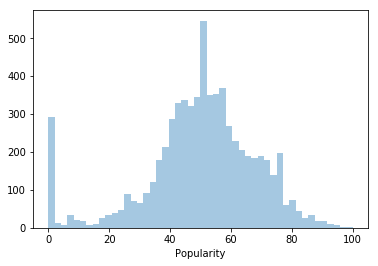

In [94]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [95]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['2LskIZrCeLxRvCiGP8gxlh', 'Arms Around You (feat. Maluma & Swae Lee)', 94],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 94],
 ['3ee8Jmje8o58CHK66QrVC2', 'SAD!', 94],
 ['4S8d14HvHb70ImctNgVzQQ', 'I Love It (& Lil Pump)', 94],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 95],
 ['5N5k9nd479b1xpDZ4usjrg', 'Promises (with Sam Smith)', 95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 96],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['2dpaYNEQHiRxtZbfNsse99', 'Happier', 98],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  100]]

## Feature Extraction

In [96]:
sp.audio_features(songs[0][0])

[{'danceability': 0.83,
  'energy': 0.653,
  'key': 1,
  'loudness': -5.298,
  'mode': 1,
  'speechiness': 0.185,
  'acousticness': 0.0469,
  'instrumentalness': 0,
  'liveness': 0.112,
  'valence': 0.228,
  'tempo': 123.032,
  'type': 'audio_features',
  'id': '002QT7AS6h1LAF5dla8D92',
  'uri': 'spotify:track:002QT7AS6h1LAF5dla8D92',
  'track_href': 'https://api.spotify.com/v1/tracks/002QT7AS6h1LAF5dla8D92',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/002QT7AS6h1LAF5dla8D92',
  'duration_ms': 207827,
  'time_signature': 4}]

In [97]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [98]:
feats = features(songs)
feats[100]

{'danceability': 0.598,
 'energy': 0.559,
 'key': 4,
 'loudness': -7.534,
 'mode': 0,
 'speechiness': 0.0616,
 'acousticness': 0.301,
 'instrumentalness': 0,
 'liveness': 0.263,
 'valence': 0.0922,
 'tempo': 171.851,
 'type': 'audio_features',
 'id': '07VizkUweZe2lQo4yWIhgA',
 'uri': 'spotify:track:07VizkUweZe2lQo4yWIhgA',
 'track_href': 'https://api.spotify.com/v1/tracks/07VizkUweZe2lQo4yWIhgA',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/07VizkUweZe2lQo4yWIhgA',
 'duration_ms': 212482,
 'time_signature': 4,
 'name': "해장국 Hero's Soup",
 'popularity': 58}

In [99]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4249,0.124000,https://api.spotify.com/v1/audio-analysis/4xlR...,0.756,344293,0.573,4xlRayuMPAiu9Vcut1eABe,0.000014,10,0.124,-8.343,0,FRIENDS,36,0.0978,143.960,4,https://api.spotify.com/v1/tracks/4xlRayuMPAiu...,audio_features,spotify:track:4xlRayuMPAiu9Vcut1eABe,0.303
5473,0.032500,https://api.spotify.com/v1/audio-analysis/6QYY...,0.401,224187,0.713,6QYYVuvynDJctOwwUTLfhX,0.000690,8,0.102,-5.982,1,King For A Day,45,0.0326,143.106,4,https://api.spotify.com/v1/tracks/6QYYVuvynDJc...,audio_features,spotify:track:6QYYVuvynDJctOwwUTLfhX,0.725
2353,0.281000,https://api.spotify.com/v1/audio-analysis/2jWV...,0.805,100430,0.738,2jWVa5zXZ04BRcpn7b7tPp,0.000036,8,0.403,-1.872,1,Left Hand,43,0.1280,137.936,4,https://api.spotify.com/v1/tracks/2jWVa5zXZ04B...,audio_features,spotify:track:2jWVa5zXZ04BRcpn7b7tPp,0.611
3848,0.000086,https://api.spotify.com/v1/audio-analysis/4V4H...,0.534,234495,0.987,4V4H6WIDHizgIlo8K1h5B5,0.000253,11,0.262,-3.544,1,Never Sure,51,0.0728,128.973,4,https://api.spotify.com/v1/tracks/4V4H6WIDHizg...,audio_features,spotify:track:4V4H6WIDHizgIlo8K1h5B5,0.561
1589,0.113000,https://api.spotify.com/v1/audio-analysis/1ptM...,0.684,248696,0.893,1ptM5l7tbT3QCbvYjtBEpV,0.000000,6,0.316,-3.266,1,Suki ni Nacchaudarou? - IZ*ONE Ver.,59,0.0576,130.963,4,https://api.spotify.com/v1/tracks/1ptM5l7tbT3Q...,audio_features,spotify:track:1ptM5l7tbT3QCbvYjtBEpV,0.810


In [100]:
data.loc[data['popularity'] == 100]

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4229,0.153,https://api.spotify.com/v1/audio-analysis/4w8n...,0.841,212500,0.798,4w8niZpiMy6qz1mntFA5uM,0.000003,1,0.0618,-4.206,0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",100,0.229,95.948,4,https://api.spotify.com/v1/tracks/4w8niZpiMy6q...,audio_features,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591


In [101]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence"]

In [102]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 4677, Dev size: 1003, Test size: 1003


## Baseline (Linear Regression)

In [103]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [104]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 279.6201658896808
Variance Score: -2.893319131893265


In [105]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': -2.82855840888329, 'danceability': 21.096403269479193, 'energy': -9.24199179409083, 'loudness': 1.296963365486737, 'speechiness': -0.07094963811853924, 'tempo': 0.0055212419245092926, 'valence': -9.747544166150785}


## SVM 

In [106]:
svr = SVR(gamma='scale')
svr.fit(x_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [107]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 295.71986462613523
SVM Variance Score: -6.874287373283961


## Random Forest

In [108]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [109]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 250.4178061546869
Random Forest Variance Score: -1.0019772878824798
